In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np 
import pandas as pd
from scipy import stats
import itertools
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import *
from keras import backend as K
from keras.models import load_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold
import h5py
import pickle

sns.set(style='ticks', palette='muted', font_scale=1.5)

Using TensorFlow backend.


In [2]:
BI_CLASSES = [('Downstairs', 'Upstairs'), ('Downstairs', 'Walking'), ('Jogging', 'Upstairs'), ('Jogging', 'Walking'), ('Upstairs', 'Walking')]
N_CLASSES = 6
N_TIME_STEPS = 200
N_FEATURES = 3

N_EPOCHS = 170
BATCH_SIZE = 1024
LEARNING_RATE = 0.0001

In [3]:
def tf_swish(x):
    return x * tf.nn.sigmoid(x)

def ks_swish(x):
    return x * K.sigmoid(x)

def cnn_model():
    model = Sequential()
    model.add(Conv2D(128, (2, 2), input_shape=(N_TIME_STEPS, N_FEATURES, 1)))
    model.add(Activation(ks_swish))
    model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation(ks_swish))
    model.add(Dense(128))
    model.add(Activation(ks_swish))
    model.add(Dense(2, activation='softmax'))
    adam = optimizers.Adam(lr = LEARNING_RATE, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

def feature_normalize(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.std(dataset, axis = 0)
    return (dataset - mu) / sigma

def segment_signal(data, N_TIME_STEPS = 200, step = 20):
    segments = [] 
    labels = []
    for i in range(0, len(data) - N_TIME_STEPS, step):
        xs = data['x-axis'].values[i: i + N_TIME_STEPS]
        ys = data['y-axis'].values[i: i + N_TIME_STEPS]
        zs = data['z-axis'].values[i: i + N_TIME_STEPS]
        label = stats.mode(data['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    return segments, labels

def combinations(combination, features, labels):
    combinations_x = [0] * len(combination)
    combinations_y = [0] * len(combination)
    for i in chosen:
        temp_x = [] 
        temp_y = [] 
        for k in range(2):
            for j in range(len(labels)):
                if (combination[i][k] == labels[j]):
                    temp_x.append(features[j])
                    temp_y.append(labels[j])
        combinations_x[i] = np.asarray(temp_x, dtype=np.float32).reshape(len(temp_x), N_TIME_STEPS, N_FEATURES, 1)
        combinations_y[i] = np.asarray(pd.get_dummies(temp_y), dtype=np.float32)
    return combinations_x, combinations_y

def final_prediction(X_temp_test, predictions, threshold):
    cnn_predictions = np.copy(predictions)
    i = 0
    while i < len(predictions):
        sorted_index = np.argsort(cnn_predictions[i])[::-1]
        test_cnn = X_temp_test[i].reshape(1, N_TIME_STEPS, N_FEATURES, 1)
        k = 0
        j = 1
        while j < len(sorted_index):        
            if sorted_index[k] > sorted_index[j]:
                t = int(N_CLASSES * sorted_index[j] - sorted_index[j] * (sorted_index[j] + 1) / 2 + sorted_index[k] - sorted_index[j] - 1)     
            else:
                t = int(N_CLASSES * sorted_index[k] - sorted_index[k] * (sorted_index[k] + 1) / 2 + sorted_index[j] - sorted_index[k] - 1)
            if cnn_models[t] != None:
                if threshold > cnn_predictions[i][sorted_index[k]] / cnn_predictions[i][sorted_index[j]]:    
                    p = cnn_models[t].predict(test_cnn)
                    if np.argmax(p):
                        if sorted_index[k] < sorted_index[j]:
                            k = j
                    else:
                        if sorted_index[k] > sorted_index[j]:
                            k = j
                else:
                    break;
            j = j + 1     
        cnn_predictions[i] = 0
        cnn_predictions[i][sorted_index[k]] = 1
        i = i + 1
    return cnn_predictions

def threshold_vs_accuraccy(history):
    plt.rcdefaults()
    plt.plot(history['threshold'], history['accuracy'], 'r-')
    plt.plot(history['threshold'], history['f1score'], 'g-')
    plt.show()
    
def confusion_report(predictions, y_test):
    max_test = np.argmax(y_test, axis=1)
    max_predictions = np.argmax(predictions, axis=1)
    confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

    plt.figure(figsize=(16, 14))
    sns.heatmap(confusion_matrix, xticklabels=np.unique(df.activity), yticklabels=np.unique(df.activity), annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();

In [4]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
df = df.dropna()

In [5]:
df.dtypes

user           int64
activity      object
timestamp      int64
x-axis       float64
y-axis       float64
z-axis       float64
dtype: object

In [6]:
df['x-axis'] = feature_normalize(df['x-axis'])
df['y-axis'] = feature_normalize(df['y-axis'])
df['z-axis'] = feature_normalize(df['z-axis'])

In [7]:
segments, labels = segment_signal(df)

c:\users\kinai\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [8]:
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)

In [9]:
combination = list(itertools.combinations(np.unique(labels, axis=0), 2))
n_combination = len(combination)
print("Combinations: ", n_combination)
print(combination)

Combinations:  15
[('Downstairs', 'Jogging'), ('Downstairs', 'Sitting'), ('Downstairs', 'Standing'), ('Downstairs', 'Upstairs'), ('Downstairs', 'Walking'), ('Jogging', 'Sitting'), ('Jogging', 'Standing'), ('Jogging', 'Upstairs'), ('Jogging', 'Walking'), ('Sitting', 'Standing'), ('Sitting', 'Upstairs'), ('Sitting', 'Walking'), ('Standing', 'Upstairs'), ('Standing', 'Walking'), ('Upstairs', 'Walking')]


In [10]:
chosen = []
for i in range(len(BI_CLASSES)):
    chosen.append(combination.index(BI_CLASSES[i]))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.3, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [12]:
X_c_train, y_c_train = combinations(combination, X_train, y_train)
X_c_validation, y_c_validation = combinations(combination, X_validation, y_validation)

In [13]:
y_train = np.asarray(pd.get_dummies(y_train), dtype = np.float32)
y_test = np.asarray(pd.get_dummies(y_test), dtype = np.float32)
y_validation = np.asarray(pd.get_dummies(y_validation), dtype = np.float32)

In [14]:
N_HIDDEN_UNITS = 128
keep_prob_ = tf.placeholder(tf.float32, name = 'keep')

In [15]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }

    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf_swish(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

In [16]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

L2_LOSS = 0.0015

l2 = L2_LOSS * \
        sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

In [18]:
history = dict(train_loss=[], train_acc=[], test_loss=[], test_acc=[])

sess = tf.InteractiveSession()  
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE), range(BATCH_SIZE, train_count + 1, BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end], Y: y_train[start:end]})

    train_predictions, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)
        
    if i != 1 and i % 10 != 0:
        continue

    print('epoch:', i, 'train accuracy:', acc_train, 'loss train:', loss_train, 'test accuracy:', acc_test, 'test loss:', loss_test)
    
predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})
validation_predictions, validation_acc, validation_loss = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_validation, Y: y_validation})
print()
print('final results: accuracy:', acc_final, 'loss:', loss_final, 'validation accuracy:', validation_acc, 'validation loss:', validation_loss)

epoch: 1 train accuracy: 0.61976963 loss train: 2.5724485 test accuracy: 0.6225487 test loss: 2.56699
epoch: 10 train accuracy: 0.8620151 loss train: 1.8494503 test accuracy: 0.8631534 test loss: 1.8498529
epoch: 20 train accuracy: 0.9142322 loss train: 1.6865326 test accuracy: 0.91245216 test loss: 1.6933633
epoch: 30 train accuracy: 0.90070087 loss train: 1.6838657 test accuracy: 0.89788115 test loss: 1.6975715
epoch: 40 train accuracy: 0.93792933 loss train: 1.5452534 test accuracy: 0.93339807 test loss: 1.5645137
epoch: 50 train accuracy: 0.95687324 loss train: 1.4733342 test accuracy: 0.949062 test loss: 1.4978774
epoch: 60 train accuracy: 0.9700576 loss train: 1.4071336 test accuracy: 0.9629652 test loss: 1.4311687
epoch: 70 train accuracy: 0.97123724 loss train: 1.3769563 test accuracy: 0.9634509 test loss: 1.4023638
epoch: 80 train accuracy: 0.9767539 loss train: 1.3305762 test accuracy: 0.96794367 test loss: 1.3639926
epoch: 90 train accuracy: 0.9826868 loss train: 1.2860868 t

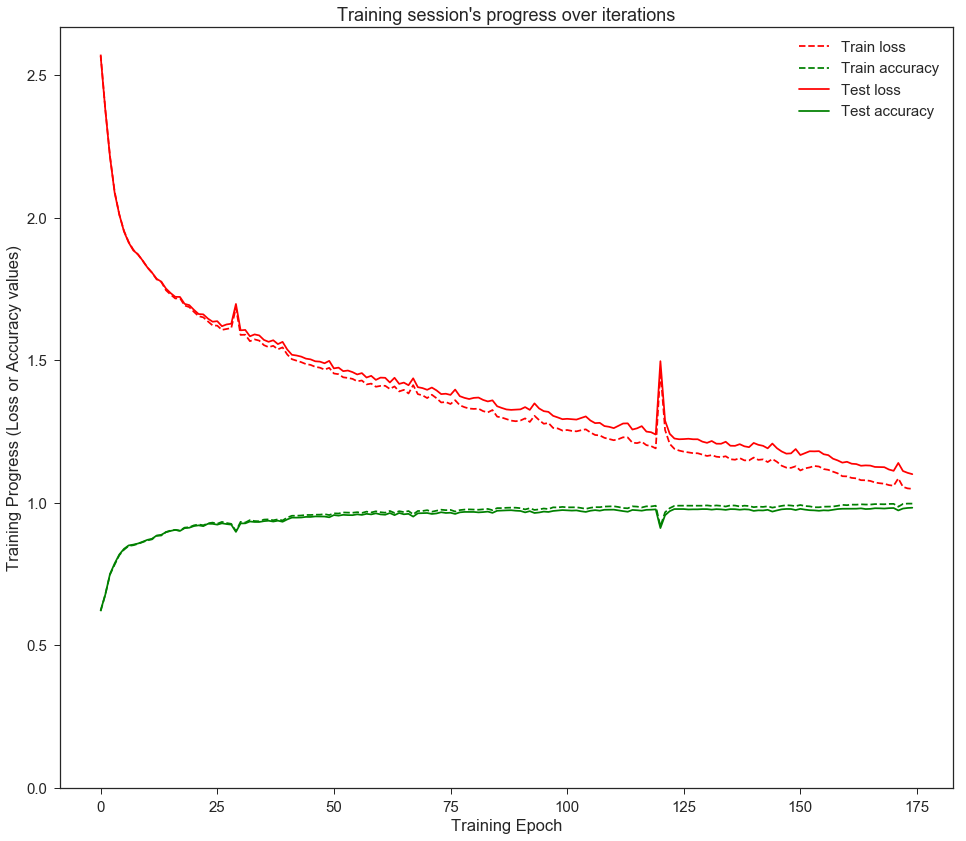

In [19]:
plt.figure(figsize=(16, 14))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

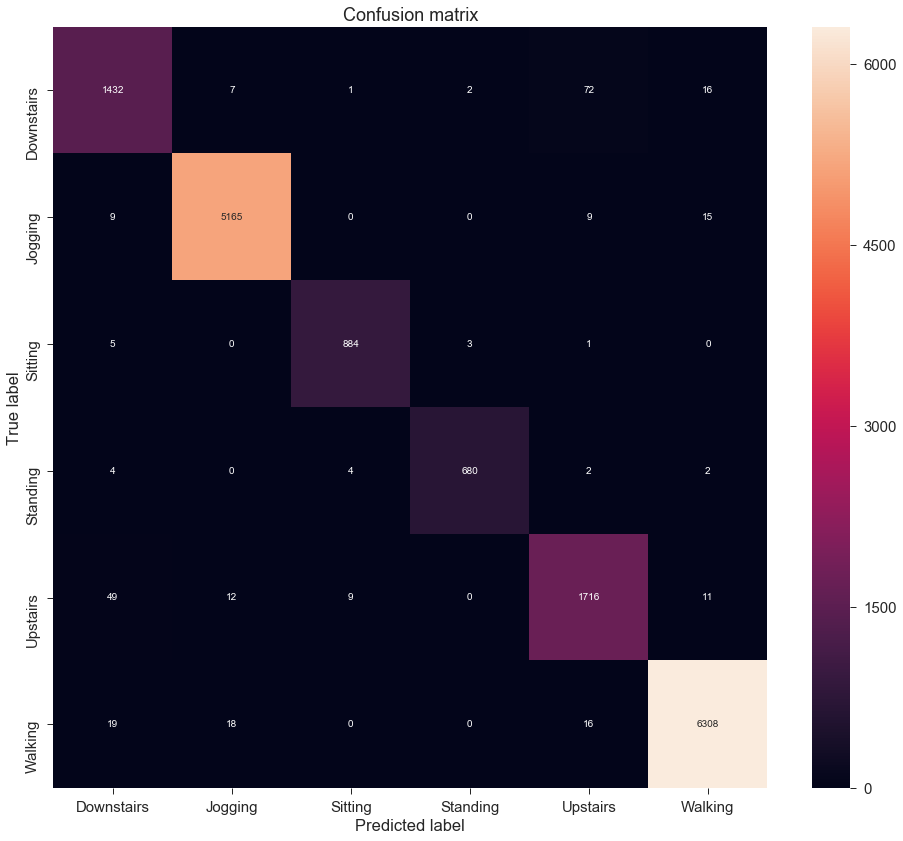

In [20]:
confusion_report(predictions, y_test)

In [21]:
batch_size = [4, 8, 16, 32]
#batch_size = [128]
param_grid = dict(batch_size = batch_size)
earlyStopping = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 0, mode = 'auto')
cnn_models = [None] * n_combination
for i in chosen:    
    model = KerasClassifier(build_fn = cnn_model)
    grid = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5)
    grid.fit(X_c_train[i], y_c_train[i], epochs = N_EPOCHS, callbacks = [earlyStopping], validation_data = (X_c_validation[i], y_c_validation[i]))
    print("Best: %f using %s" %(grid.best_score_, grid.best_params_))
    cnn_models[i] = grid.best_estimator_.model

Train on 4700 samples, validate on 1962 samples
Epoch 1/500
4700/4700 [==============================] - 46s 10ms/step - loss: 0.5827 - acc: 0.7189 - val_loss: 0.6456 - val_acc: 0.6346
Epoch 2/500
4700/4700 [==============================] - 37s 8ms/step - loss: 0.5054 - acc: 0.7591 - val_loss: 0.6067 - val_acc: 0.6738
Epoch 3/500
4700/4700 [==============================] - 38s 8ms/step - loss: 0.4212 - acc: 0.8094 - val_loss: 0.4851 - val_acc: 0.7574
Epoch 4/500
4700/4700 [==============================] - 37s 8ms/step - loss: 0.3419 - acc: 0.8487 - val_loss: 0.4656 - val_acc: 0.7773
Epoch 5/500
4700/4700 [==============================] - 37s 8ms/step - loss: 0.2743 - acc: 0.8849 - val_loss: 0.4580 - val_acc: 0.7875
Epoch 6/500
4700/4700 [==============================] - 37s 8ms/step - loss: 0.2214 - acc: 0.9074 - val_loss: 0.4747 - val_acc: 0.7895
Epoch 7/500
4700/4700 [==============================] - 37s 8ms/step - loss: 0.1703 - acc: 0.9321 - val_loss: 0.4172 - val_acc: 0.8262

4700/4700 [==============================] - 20s 4ms/step - loss: 0.2573 - acc: 0.8960 - val_loss: 0.3918 - val_acc: 0.8201
Epoch 8/500
4700/4700 [==============================] - 20s 4ms/step - loss: 0.2176 - acc: 0.9128 - val_loss: 0.4232 - val_acc: 0.8145
Epoch 9/500
4700/4700 [==============================] - 20s 4ms/step - loss: 0.1847 - acc: 0.9291 - val_loss: 0.3907 - val_acc: 0.8369
Epoch 10/500
4700/4700 [==============================] - 20s 4ms/step - loss: 0.1496 - acc: 0.9443 - val_loss: 0.3992 - val_acc: 0.8344
Epoch 11/500
4700/4700 [==============================] - 20s 4ms/step - loss: 0.1250 - acc: 0.9521 - val_loss: 0.4342 - val_acc: 0.8282
Epoch 12/500
4700/4700 [==============================] - 21s 5ms/step - loss: 0.1018 - acc: 0.9653 - val_loss: 0.4339 - val_acc: 0.8303
Epoch 13/500
4700/4700 [==============================] - 21s 4ms/step - loss: 0.0801 - acc: 0.9777 - val_loss: 0.5546 - val_acc: 0.8170
Epoch 14/500
4700/4700 [==============================] 

4700/4700 [==============================] - 13s 3ms/step - loss: 0.6248 - acc: 0.6953 - val_loss: 0.6742 - val_acc: 0.5617
Epoch 2/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.5675 - acc: 0.7200 - val_loss: 0.6308 - val_acc: 0.6448
Epoch 3/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.5331 - acc: 0.7436 - val_loss: 0.6484 - val_acc: 0.6295
Epoch 4/500
4700/4700 [==============================] - 10s 2ms/step - loss: 0.4960 - acc: 0.7615 - val_loss: 0.6153 - val_acc: 0.6631
Epoch 5/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.4634 - acc: 0.7857 - val_loss: 0.5686 - val_acc: 0.7090
Epoch 6/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.4273 - acc: 0.8094 - val_loss: 0.5755 - val_acc: 0.6922
Epoch 7/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.3982 - acc: 0.8211 - val_loss: 0.6031 - val_acc: 0.6830
Epoch 8/500
4700/4700 [==============================] - 9s 2ms/s

4700/4700 [==============================] - 9s 2ms/step - loss: 0.1253 - acc: 0.9553 - val_loss: 0.4022 - val_acc: 0.8466
Epoch 21/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.0984 - acc: 0.9702 - val_loss: 0.4101 - val_acc: 0.8430
Epoch 22/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.0964 - acc: 0.9679 - val_loss: 0.4113 - val_acc: 0.8481
Epoch 23/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.0791 - acc: 0.9791 - val_loss: 0.4323 - val_acc: 0.8384
Epoch 24/500
4700/4700 [==============================] - 9s 2ms/step - loss: 0.0722 - acc: 0.9798 - val_loss: 0.4216 - val_acc: 0.8507
Epoch 25/500
4700/4700 [==============================] - 2s 398us/step
Train on 4700 samples, validate on 1962 samples
Epoch 1/500
4700/4700 [==============================] - 13s 3ms/step - loss: 0.6671 - acc: 0.5862 - val_loss: 0.6693 - val_acc: 0.5596
Epoch 2/500
4700/4700 [==============================] - 9s 2ms/step - loss: 

10978/10978 [==============================] - 12s 1ms/step
Train on 10978 samples, validate on 4641 samples
Epoch 1/500
10978/10978 [==============================] - 97s 9ms/step - loss: 0.3829 - acc: 0.8423 - val_loss: 0.1935 - val_acc: 0.9293
Epoch 2/500
10978/10978 [==============================] - 93s 8ms/step - loss: 0.1284 - acc: 0.9508 - val_loss: 0.1041 - val_acc: 0.9606
Epoch 3/500
10978/10978 [==============================] - 92s 8ms/step - loss: 0.0712 - acc: 0.9735 - val_loss: 0.0772 - val_acc: 0.9713
Epoch 4/500
10978/10978 [==============================] - 90s 8ms/step - loss: 0.0412 - acc: 0.9862 - val_loss: 0.0724 - val_acc: 0.9757
Epoch 5/500
10978/10978 [==============================] - 92s 8ms/step - loss: 0.0258 - acc: 0.9914 - val_loss: 0.0746 - val_acc: 0.9767
Epoch 6/500
10978/10978 [==============================] - 92s 8ms/step - loss: 0.0128 - acc: 0.9970 - val_loss: 0.0735 - val_acc: 0.9765
Epoch 7/500
10978/10978 [==============================] - 93s 

10977/10977 [==============================] - 31s 3ms/step - loss: 0.0180 - acc: 0.9962 - val_loss: 0.0722 - val_acc: 0.9752
Epoch 11/500
10977/10977 [==============================] - 31s 3ms/step - loss: 0.0121 - acc: 0.9978 - val_loss: 0.0911 - val_acc: 0.9716
Epoch 12/500
10977/10977 [==============================] - 31s 3ms/step - loss: 0.0111 - acc: 0.9973 - val_loss: 0.0834 - val_acc: 0.9748
Epoch 13/500
10977/10977 [==============================] - 32s 3ms/step - loss: 0.0060 - acc: 0.9994 - val_loss: 0.0765 - val_acc: 0.9772
Epoch 14/500
10977/10977 [==============================] - 31s 3ms/step - loss: 0.0047 - acc: 0.9996 - val_loss: 0.0827 - val_acc: 0.9769
Epoch 15/500
10977/10977 [==============================] - 31s 3ms/step - loss: 0.0071 - acc: 0.9983 - val_loss: 0.0709 - val_acc: 0.9810
Epoch 16/500
10977/10977 [==============================] - 31s 3ms/step - loss: 0.0035 - acc: 0.9993 - val_loss: 0.0762 - val_acc: 0.9793
Epoch 17/500
10977/10977 [==============

10978/10978 [==============================] - 22s 2ms/step - loss: 0.0213 - acc: 0.9942 - val_loss: 0.0852 - val_acc: 0.9709
Epoch 17/500
10978/10978 [==============================] - 21s 2ms/step - loss: 0.0131 - acc: 0.9983 - val_loss: 0.1004 - val_acc: 0.9634
Epoch 18/500
10978/10978 [==============================] - 22s 2ms/step - loss: 0.0120 - acc: 0.9976 - val_loss: 0.1008 - val_acc: 0.9666
Epoch 19/500
10978/10978 [==============================] - 21s 2ms/step - loss: 0.0090 - acc: 0.9989 - val_loss: 0.0923 - val_acc: 0.9726
Epoch 20/500
10978/10978 [==============================] - 22s 2ms/step - loss: 0.0078 - acc: 0.9987 - val_loss: 0.0927 - val_acc: 0.9707
Epoch 21/500
10978/10978 [==============================] - 5s 414us/step
Train on 10978 samples, validate on 4641 samples
Epoch 1/500
10978/10978 [==============================] - 27s 2ms/step - loss: 0.4790 - acc: 0.7929 - val_loss: 0.3742 - val_acc: 0.8552
Epoch 2/500
10978/10978 [==============================] 

Epoch 23/500
10978/10978 [==============================] - 22s 2ms/step - loss: 0.0041 - acc: 0.9995 - val_loss: 0.0971 - val_acc: 0.9733
Epoch 24/500
10978/10978 [==============================] - 22s 2ms/step - loss: 0.0032 - acc: 0.9997 - val_loss: 0.0822 - val_acc: 0.9782
Epoch 25/500
10978/10978 [==============================] - 22s 2ms/step - loss: 0.0062 - acc: 0.9986 - val_loss: 0.0838 - val_acc: 0.9793
Epoch 26/500
10978/10978 [==============================] - 22s 2ms/step - loss: 0.0196 - acc: 0.9957 - val_loss: 0.0914 - val_acc: 0.9765
Epoch 27/500
10978/10978 [==============================] - 5s 427us/step
Train on 13722 samples, validate on 4641 samples
Epoch 1/500
13722/13722 [==============================] - 123s 9ms/step - loss: 0.3427 - acc: 0.8668 - val_loss: 0.2028 - val_acc: 0.9186
Epoch 2/500
13722/13722 [==============================] - 116s 8ms/step - loss: 0.1347 - acc: 0.9467 - val_loss: 0.1116 - val_acc: 0.9621
Epoch 3/500
13722/13722 [==================

9789/9789 [==============================] - 48s 5ms/step - loss: 0.0039 - acc: 0.9991 - val_loss: 0.0572 - val_acc: 0.9850
Epoch 12/500
9789/9789 [==============================] - 47s 5ms/step - loss: 0.0035 - acc: 0.9992 - val_loss: 0.0598 - val_acc: 0.9860
Epoch 13/500
9789/9789 [==============================] - 7s 739us/step
Train on 9790 samples, validate on 4003 samples
Epoch 1/500
9790/9790 [==============================] - 54s 6ms/step - loss: 0.1428 - acc: 0.9476 - val_loss: 0.0760 - val_acc: 0.9743
Epoch 2/500
9790/9790 [==============================] - 47s 5ms/step - loss: 0.0764 - acc: 0.9740 - val_loss: 0.0694 - val_acc: 0.9760
Epoch 3/500
9790/9790 [==============================] - 47s 5ms/step - loss: 0.0591 - acc: 0.9797 - val_loss: 0.0637 - val_acc: 0.9788
Epoch 4/500
9790/9790 [==============================] - 47s 5ms/step - loss: 0.0464 - acc: 0.9837 - val_loss: 0.0637 - val_acc: 0.9790
Epoch 5/500
9790/9790 [==============================] - 48s 5ms/step - los

9790/9790 [==============================] - 29s 3ms/step - loss: 0.0089 - acc: 0.9971 - val_loss: 0.0914 - val_acc: 0.9765
Epoch 9/500
9790/9790 [==============================] - 6s 569us/step
Train on 9789 samples, validate on 4003 samples
Epoch 1/500
9789/9789 [==============================] - 27s 3ms/step - loss: 0.1971 - acc: 0.9217 - val_loss: 0.0851 - val_acc: 0.9713
Epoch 2/500
9789/9789 [==============================] - 20s 2ms/step - loss: 0.0911 - acc: 0.9707 - val_loss: 0.0729 - val_acc: 0.9755
Epoch 3/500
9789/9789 [==============================] - 20s 2ms/step - loss: 0.0716 - acc: 0.9776 - val_loss: 0.0672 - val_acc: 0.9770
Epoch 4/500
9789/9789 [==============================] - 20s 2ms/step - loss: 0.0593 - acc: 0.9800 - val_loss: 0.0642 - val_acc: 0.9788
Epoch 5/500
9789/9789 [==============================] - 20s 2ms/step - loss: 0.0516 - acc: 0.9842 - val_loss: 0.0692 - val_acc: 0.9780
Epoch 6/500
9789/9789 [==============================] - 20s 2ms/step - loss:

16067/16067 [==============================] - 24s 1ms/step
Train on 16067 samples, validate on 6682 samples
Epoch 1/500
16067/16067 [==============================] - 156s 10ms/step - loss: 0.0577 - acc: 0.9846 - val_loss: 0.0302 - val_acc: 0.9912
Epoch 2/500
16067/16067 [==============================] - 147s 9ms/step - loss: 0.0246 - acc: 0.9931 - val_loss: 0.0264 - val_acc: 0.99343s - loss: 0.0251 - acc
Epoch 3/500
16067/16067 [==============================] - 147s 9ms/step - loss: 0.0157 - acc: 0.9948 - val_loss: 0.0326 - val_acc: 0.9919
Epoch 4/500
16067/16067 [==============================] - 147s 9ms/step - loss: 0.0084 - acc: 0.9974 - val_loss: 0.0228 - val_acc: 0.9939
Epoch 5/500
16067/16067 [==============================] - 147s 9ms/step - loss: 0.0051 - acc: 0.9981 - val_loss: 0.0245 - val_acc: 0.9942
Epoch 6/500
16067/16067 [==============================] - 147s 9ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0273 - val_acc: 0.9934
Epoch 7/500
16067/16067 [========

16067/16067 [==============================] - 54s 3ms/step - loss: 0.0780 - acc: 0.9788 - val_loss: 0.0320 - val_acc: 0.9921
Epoch 2/500
16067/16067 [==============================] - 46s 3ms/step - loss: 0.0244 - acc: 0.9940 - val_loss: 0.0287 - val_acc: 0.9922
Epoch 3/500
16067/16067 [==============================] - 45s 3ms/step - loss: 0.0179 - acc: 0.9947 - val_loss: 0.0261 - val_acc: 0.9927
Epoch 4/500
16067/16067 [==============================] - 45s 3ms/step - loss: 0.0135 - acc: 0.9964 - val_loss: 0.0259 - val_acc: 0.9919
Epoch 5/500
16067/16067 [==============================] - 45s 3ms/step - loss: 0.0101 - acc: 0.9968 - val_loss: 0.0288 - val_acc: 0.9922
Epoch 6/500
16067/16067 [==============================] - 46s 3ms/step - loss: 0.0055 - acc: 0.9981 - val_loss: 0.0296 - val_acc: 0.9931
Epoch 7/500
16067/16067 [==============================] - 45s 3ms/step - loss: 0.0061 - acc: 0.9979 - val_loss: 0.0378 - val_acc: 0.9918
Epoch 8/500
16067/16067 [=====================

16068/16068 [==============================] - 35s 2ms/step - loss: 0.0247 - acc: 0.9927 - val_loss: 0.0253 - val_acc: 0.9931
Epoch 4/500
16068/16068 [==============================] - 36s 2ms/step - loss: 0.0187 - acc: 0.9948 - val_loss: 0.0252 - val_acc: 0.9933
Epoch 5/500
16068/16068 [==============================] - 37s 2ms/step - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0240 - val_acc: 0.9931
Epoch 6/500
16068/16068 [==============================] - 35s 2ms/step - loss: 0.0087 - acc: 0.9974 - val_loss: 0.0285 - val_acc: 0.9912
Epoch 7/500
16068/16068 [==============================] - 35s 2ms/step - loss: 0.0057 - acc: 0.9984 - val_loss: 0.0268 - val_acc: 0.9922
Epoch 8/500
16068/16068 [==============================] - 36s 2ms/step - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0279 - val_acc: 0.9933
Epoch 9/500
16068/16068 [==============================] - 37s 2ms/step - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0245 - val_acc: 0.9939
Epoch 10/500
16068/16068 [====================

Epoch 6/500
11501/11501 [==============================] - 62s 5ms/step - loss: 0.0609 - acc: 0.9781 - val_loss: 0.1148 - val_acc: 0.9618
Epoch 7/500
11501/11501 [==============================] - 61s 5ms/step - loss: 0.0396 - acc: 0.9871 - val_loss: 0.1004 - val_acc: 0.9683
Epoch 8/500
11501/11501 [==============================] - 60s 5ms/step - loss: 0.0297 - acc: 0.9906 - val_loss: 0.0897 - val_acc: 0.9708
Epoch 9/500
11501/11501 [==============================] - 59s 5ms/step - loss: 0.0229 - acc: 0.9940 - val_loss: 0.1163 - val_acc: 0.9627
Epoch 10/500
11501/11501 [==============================] - 59s 5ms/step - loss: 0.0160 - acc: 0.9957 - val_loss: 0.0941 - val_acc: 0.9712
Epoch 11/500
11501/11501 [==============================] - 59s 5ms/step - loss: 0.0112 - acc: 0.9971 - val_loss: 0.0895 - val_acc: 0.9755
Epoch 12/500
11501/11501 [==============================] - 61s 5ms/step - loss: 0.0117 - acc: 0.9968 - val_loss: 0.0958 - val_acc: 0.9734
Epoch 13/500
11501/11501 [=====

11502/11502 [==============================] - 36s 3ms/step - loss: 0.0404 - acc: 0.9880 - val_loss: 0.1024 - val_acc: 0.9652
Epoch 10/500
11502/11502 [==============================] - 35s 3ms/step - loss: 0.0350 - acc: 0.9896 - val_loss: 0.0989 - val_acc: 0.9666
Epoch 11/500
11502/11502 [==============================] - 35s 3ms/step - loss: 0.0245 - acc: 0.9930 - val_loss: 0.0901 - val_acc: 0.9689
Epoch 12/500
11502/11502 [==============================] - 35s 3ms/step - loss: 0.0187 - acc: 0.9950 - val_loss: 0.0914 - val_acc: 0.9716
Epoch 13/500
11502/11502 [==============================] - 35s 3ms/step - loss: 0.0185 - acc: 0.9941 - val_loss: 0.1027 - val_acc: 0.9681
Epoch 14/500
11502/11502 [==============================] - 35s 3ms/step - loss: 0.0121 - acc: 0.9966 - val_loss: 0.0824 - val_acc: 0.9759
Epoch 15/500
11502/11502 [==============================] - 35s 3ms/step - loss: 0.0094 - acc: 0.9976 - val_loss: 0.0872 - val_acc: 0.9747
Epoch 16/500
11502/11502 [==============

11502/11502 [==============================] - 6s 485us/step
Train on 11502 samples, validate on 4821 samples
Epoch 1/500
11502/11502 [==============================] - 34s 3ms/step - loss: 0.4759 - acc: 0.7685 - val_loss: 0.3535 - val_acc: 0.8515
Epoch 2/500
11502/11502 [==============================] - 23s 2ms/step - loss: 0.3242 - acc: 0.8632 - val_loss: 0.2616 - val_acc: 0.9000
Epoch 3/500
11502/11502 [==============================] - 23s 2ms/step - loss: 0.2508 - acc: 0.9024 - val_loss: 0.2737 - val_acc: 0.8814
Epoch 4/500
11502/11502 [==============================] - 23s 2ms/step - loss: 0.2017 - acc: 0.9213 - val_loss: 0.1881 - val_acc: 0.9313
Epoch 5/500
11502/11502 [==============================] - 23s 2ms/step - loss: 0.1620 - acc: 0.9411 - val_loss: 0.1763 - val_acc: 0.9355
Epoch 6/500
11502/11502 [==============================] - 23s 2ms/step - loss: 0.1333 - acc: 0.9514 - val_loss: 0.1471 - val_acc: 0.9465
Epoch 7/500
11502/11502 [==============================] - 23s

In [22]:
validation_history = dict(accuracy=[], f1score=[], threshold=[])
threshold = 0
while (threshold < 10):    
    c_predictions = final_prediction(X_validation, validation_predictions, threshold)
    accuracy = accuracy_score(np.argmax(y_validation, 1), np.argmax(c_predictions, 1)) 
    f1score = f1_score(np.argmax(y_validation, 1), np.argmax(c_predictions, 1), average='weighted')
    print("accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)
    threshold += 0.01
    validation_history['accuracy'].append(accuracy)
    validation_history['f1score'].append(f1score)
    validation_history['threshold'].append(threshold)

accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.01
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.02
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.03
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.04
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.05
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.060000000000000005
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.07
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.08
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.09
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.09999999999999999
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.10999999999999999
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 

accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.9600000000000006
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.9700000000000006
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.9800000000000006
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 0.9900000000000007
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 1.0000000000000007
accuracy: 0.9805370524562864 f1_score: 0.9805943051480839 threshold: 1.0100000000000007
accuracy: 0.9805370524562864 f1_score: 0.9805970544653712 threshold: 1.0200000000000007
accuracy: 0.9805370524562864 f1_score: 0.9805970544653712 threshold: 1.0300000000000007
accuracy: 0.9805370524562864 f1_score: 0.9805970544653712 threshold: 1.0400000000000007
accuracy: 0.9805370524562864 f1_score: 0.9805970544653712 threshold: 1.0500000000000007
accuracy: 0.9805370524562864 f1_score: 0.9805970544653712 threshold: 1.0600000000000007
accuracy: 0.9805370524562864 f1_

accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9000000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9100000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9200000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9300000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9400000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9500000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9600000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9700000000000015
accuracy: 0.9809533721898418 f1_score: 0.9810021858680802 threshold: 1.9800000000000015
accuracy: 0.9810574521232306 f1_score: 0.9811037767742589 threshold: 1.9900000000000015
accuracy: 0.9810574521232306 f1_score: 0.9811037767742589 threshold: 2.0000000000000013
accuracy: 0.9810574521232306 f1_

accuracy: 0.981473771856786 f1_score: 0.981523760337818 threshold: 2.849999999999983
accuracy: 0.981473771856786 f1_score: 0.981523760337818 threshold: 2.859999999999983
accuracy: 0.981473771856786 f1_score: 0.981523760337818 threshold: 2.869999999999983
accuracy: 0.981473771856786 f1_score: 0.981523760337818 threshold: 2.8799999999999826
accuracy: 0.981473771856786 f1_score: 0.981523760337818 threshold: 2.8899999999999824
accuracy: 0.981473771856786 f1_score: 0.981523760337818 threshold: 2.899999999999982
accuracy: 0.9815778517901749 f1_score: 0.9816280283289035 threshold: 2.909999999999982
accuracy: 0.9815778517901749 f1_score: 0.9816280283289035 threshold: 2.9199999999999817
accuracy: 0.9815778517901749 f1_score: 0.9816280283289035 threshold: 2.9299999999999815
accuracy: 0.9815778517901749 f1_score: 0.9816280283289035 threshold: 2.9399999999999813
accuracy: 0.9815778517901749 f1_score: 0.9816280283289035 threshold: 2.949999999999981
accuracy: 0.981473771856786 f1_score: 0.9815265223

accuracy: 0.9817860116569526 f1_score: 0.9818422804604746 threshold: 3.789999999999963
accuracy: 0.9817860116569526 f1_score: 0.9818422804604746 threshold: 3.799999999999963
accuracy: 0.9817860116569526 f1_score: 0.9818422804604746 threshold: 3.8099999999999627
accuracy: 0.9817860116569526 f1_score: 0.9818422804604746 threshold: 3.8199999999999625
accuracy: 0.9817860116569526 f1_score: 0.9818422804604746 threshold: 3.8299999999999623
accuracy: 0.9817860116569526 f1_score: 0.9818422804604746 threshold: 3.839999999999962
accuracy: 0.9817860116569526 f1_score: 0.9818422804604746 threshold: 3.849999999999962
accuracy: 0.9816819317235637 f1_score: 0.9817406536369794 threshold: 3.8599999999999617
accuracy: 0.9817860116569526 f1_score: 0.9818436476161376 threshold: 3.8699999999999615
accuracy: 0.9817860116569526 f1_score: 0.9818436476161376 threshold: 3.8799999999999613
accuracy: 0.9817860116569526 f1_score: 0.9818436476161376 threshold: 3.889999999999961
accuracy: 0.9817860116569526 f1_score

accuracy: 0.9818900915903414 f1_score: 0.9819417568477188 threshold: 4.739999999999943
accuracy: 0.9818900915903414 f1_score: 0.9819417568477188 threshold: 4.749999999999943
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.759999999999943
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.769999999999943
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.7799999999999425
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.789999999999942
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.799999999999942
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.809999999999942
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.819999999999942
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.8299999999999415
accuracy: 0.9818900915903414 f1_score: 0.9819391571018279 threshold: 4.839999999999941
accuracy: 0.9818900915903414 f1_score: 0.

accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.689999999999923
accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.699999999999923
accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.709999999999923
accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.7199999999999225
accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.729999999999922
accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.739999999999922
accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.749999999999922
accuracy: 0.981473771856786 f1_score: 0.9815182775245437 threshold: 5.759999999999922
accuracy: 0.9815778517901749 f1_score: 0.9816197467867072 threshold: 5.769999999999921
accuracy: 0.9815778517901749 f1_score: 0.9816197467867072 threshold: 5.779999999999921
accuracy: 0.9815778517901749 f1_score: 0.9816197467867072 threshold: 5.789999999999921
accuracy: 0.9815778517901749 f1_score: 0.981619746

accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.639999999999903
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.649999999999903
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.659999999999902
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.669999999999902
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.679999999999902
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.689999999999902
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.699999999999902
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.709999999999901
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.719999999999901
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.729999999999901
accuracy: 0.981473771856786 f1_score: 0.9815133127710889 threshold: 6.739999999999901
accuracy: 0.981473771856786 f1_score: 0.98151331277108

accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.589999999999883
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.599999999999882
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.609999999999882
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.619999999999882
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.629999999999882
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.6399999999998816
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.649999999999881
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.659999999999881
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.669999999999881
accuracy: 0.980849292256453 f1_score: 0.9808949773921326 threshold: 7.679999999999881
accuracy: 0.980849292256453 f1_score: 0.9808922098237042 threshold: 7.6899999999998805
accuracy: 0.980849292256453 f1_score: 0.980892209823

accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.549999999999862
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.559999999999862
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.569999999999862
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.579999999999862
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.589999999999861
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.599999999999861
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.60999999999986
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.61999999999986
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.62999999999986
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.63999999999986
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 threshold: 8.64999999999986
accuracy: 0.980849292256453 f1_score: 0.9808923754887517 th

accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.499999999999842
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.509999999999842
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.519999999999841
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.529999999999841
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.539999999999841
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.54999999999984
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.55999999999984
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.56999999999984
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.57999999999984
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.58999999999984
accuracy: 0.9804329725228976 f1_score: 0.9804759221856854 threshold: 9.59999999999984
accuracy: 0.9804329725228976 f1_score: 0.98047592

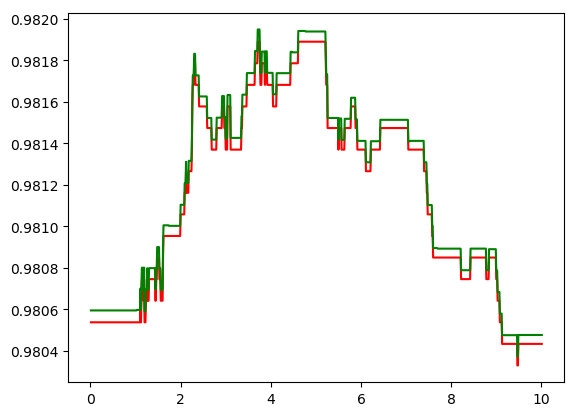

In [23]:
threshold_vs_accuraccy(validation_history)

In [24]:
threshold = validation_history['threshold'][validation_history['accuracy'].index(max(validation_history['accuracy']))]
cnn_predictions = final_prediction(X_test, predictions, threshold)
accuracy = accuracy_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1))
f1score = f1_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1), average='weighted')
print("final accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)

final accuracy: 0.984214680347277 f1_score: 0.9842214982617271 threshold: 3.709999999999965


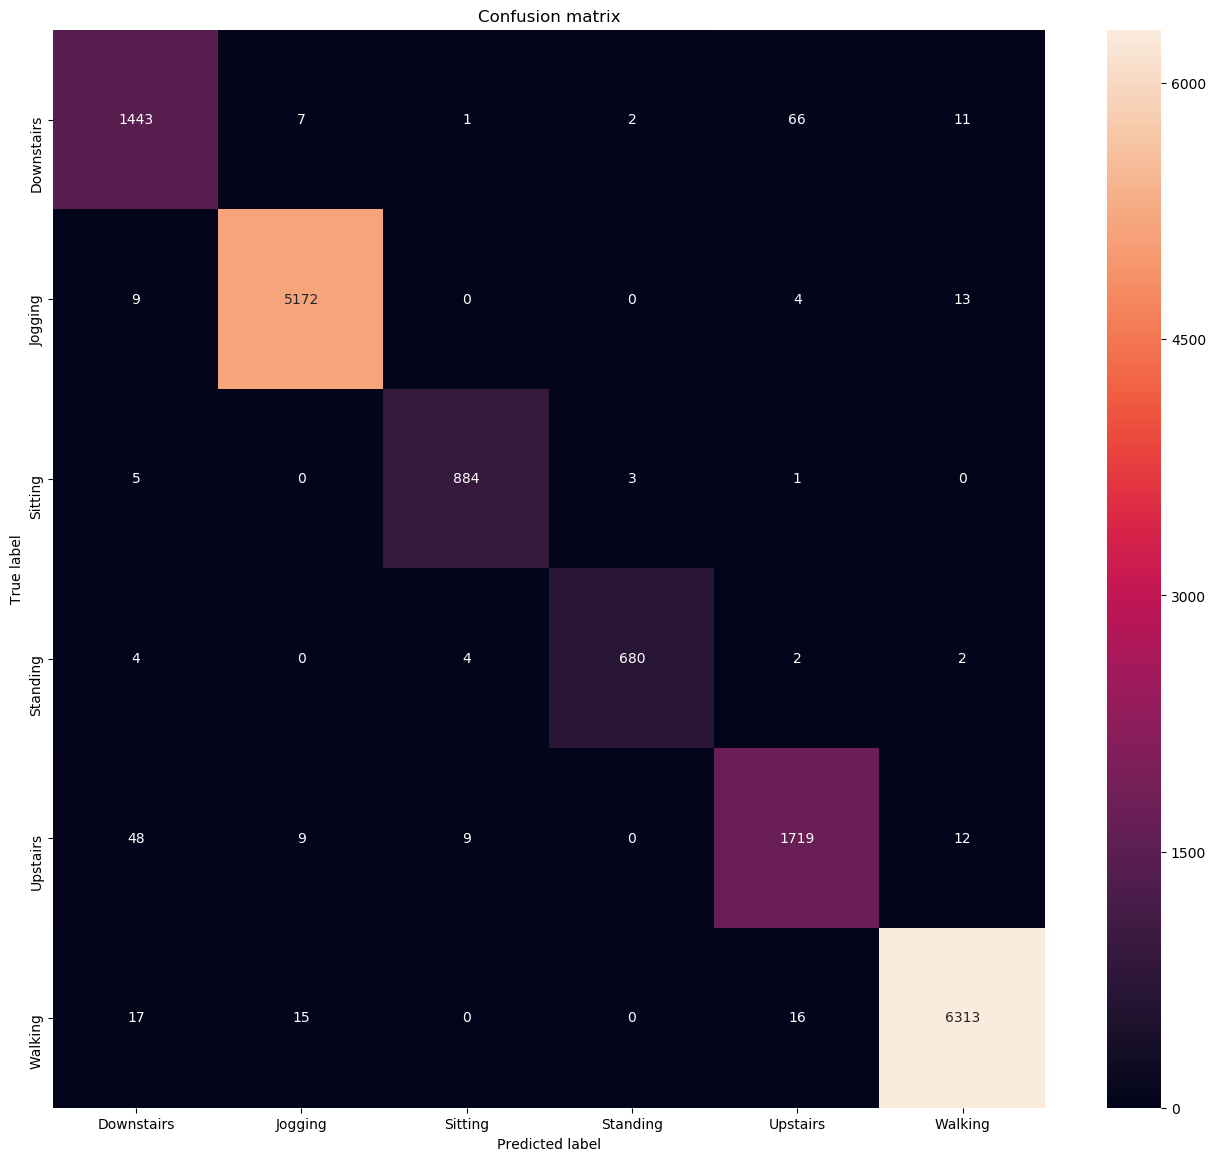

In [25]:
confusion_report(cnn_predictions, y_test)

In [26]:
print(classification_report(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1)))

             precision    recall  f1-score   support

          0       0.95      0.94      0.94      1530
          1       0.99      0.99      0.99      5198
          2       0.98      0.99      0.99       893
          3       0.99      0.98      0.99       692
          4       0.95      0.96      0.95      1797
          5       0.99      0.99      0.99      6361

avg / total       0.98      0.98      0.98     16471



In [27]:
train_history = dict(accuracy=[], f1score=[], threshold=[])
threshold = 0
while (threshold < 3):    
    cnn_predictions = final_prediction(X_train, train_predictions, threshold)
    accuracy = accuracy_score(np.argmax(y_train, 1), np.argmax(cnn_predictions, 1)) 
    f1score = f1_score(np.argmax(y_train, 1), np.argmax(cnn_predictions, 1), average='weighted')
    print("accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)
    threshold += 0.01
    train_history['accuracy'].append(accuracy)
    train_history['f1score'].append(f1score)
    train_history['threshold'].append(threshold)

accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.01
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.02
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.03
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.04
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.05
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.060000000000000005
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.07
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.08
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.09
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.09999999999999999
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.10999999999999999
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 

accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.9500000000000006
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.9600000000000006
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.9700000000000006
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.9800000000000006
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 0.9900000000000007
accuracy: 0.9970161682048435 f1_score: 0.9970171543150793 threshold: 1.0000000000000007
accuracy: 0.9970855596419402 f1_score: 0.9970866660451758 threshold: 1.0100000000000007
accuracy: 0.9970855596419402 f1_score: 0.9970866660451758 threshold: 1.0200000000000007
accuracy: 0.9970855596419402 f1_score: 0.997086669976841 threshold: 1.0300000000000007
accuracy: 0.9971202553604885 f1_score: 0.99712134253641 threshold: 1.0400000000000007
accuracy: 0.9971202553604885 f1_score: 0.99712134253641 threshold: 1.0500000000000007
accuracy: 0.9971202553604885 f1_score

accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.8900000000000015
accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.9000000000000015
accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.9100000000000015
accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.9200000000000015
accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.9300000000000015
accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.9400000000000015
accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.9500000000000015
accuracy: 0.9980223440427451 f1_score: 0.9980227649761096 threshold: 1.9600000000000015
accuracy: 0.9980570397612935 f1_score: 0.99805746646329 threshold: 1.9700000000000015
accuracy: 0.9980570397612935 f1_score: 0.99805746646329 threshold: 1.9800000000000015
accuracy: 0.9980570397612935 f1_score: 0.99805746646329 threshold: 1.9900000000000015
accuracy: 0.9980917354798418 f1_score:

accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.8299999999999836
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.8399999999999834
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.849999999999983
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.859999999999983
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.869999999999983
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.8799999999999826
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.8899999999999824
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.899999999999982
accuracy: 0.9982652140725834 f1_score: 0.9982655397904107 threshold: 2.909999999999982
accuracy: 0.9983346055096801 f1_score: 0.9983349184939982 threshold: 2.9199999999999817
accuracy: 0.9983693012282284 f1_score: 0.9983696133426365 threshold: 2.9299999999999815
accuracy: 0.9983693012282284 f1_score

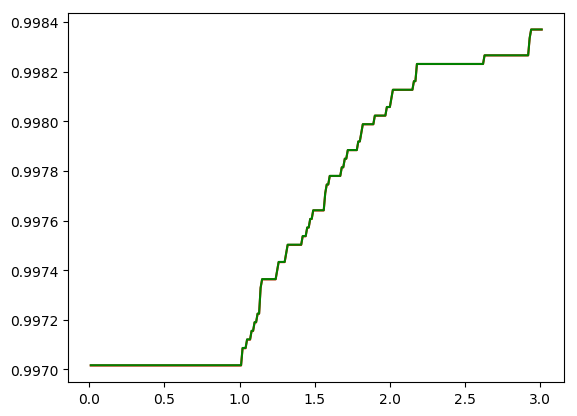

In [28]:
threshold_vs_accuraccy(train_history)

In [29]:
test_history = dict(accuracy=[], f1score=[], threshold=[])
threshold = 0
while (threshold < 10):    
    cnn_predictions = final_prediction(X_test, predictions, threshold)
    accuracy = accuracy_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1)) 
    f1score = f1_score(np.argmax(y_test, 1), np.argmax(cnn_predictions, 1), average='weighted')
    print("accuracy:", accuracy, "f1_score:", f1score,"threshold:", threshold)
    threshold += 0.01
    test_history['accuracy'].append(accuracy)
    test_history['f1score'].append(f1score)
    test_history['threshold'].append(threshold)

accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.01
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.02
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.03
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.04
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.05
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.060000000000000005
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.07
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.08
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.09
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.09999999999999999
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.10999999999999999
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.11999999999

accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.9600000000000006
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.9700000000000006
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.9800000000000006
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 0.9900000000000007
accuracy: 0.9826361483820047 f1_score: 0.982641110877415 threshold: 1.0000000000000007
accuracy: 0.9825754356141096 f1_score: 0.9825801085753681 threshold: 1.0100000000000007
accuracy: 0.9826968611498998 f1_score: 0.9827029600751357 threshold: 1.0200000000000007
accuracy: 0.9826968611498998 f1_score: 0.9827029600751357 threshold: 1.0300000000000007
accuracy: 0.98281828668569 f1_score: 0.9828272594804923 threshold: 1.0400000000000007
accuracy: 0.982757573917795 f1_score: 0.9827679695923506 threshold: 1.0500000000000007
accuracy: 0.982757573917795 f1_score: 0.9827679695923506 threshold: 1.0600000000000007
accuracy: 0.98281828668569 f1_score: 0.98

accuracy: 0.9833647015967458 f1_score: 0.9833755507160017 threshold: 1.9100000000000015
accuracy: 0.9833647015967458 f1_score: 0.9833755507160017 threshold: 1.9200000000000015
accuracy: 0.9833647015967458 f1_score: 0.9833755507160017 threshold: 1.9300000000000015
accuracy: 0.9833039888288507 f1_score: 0.9833152510584525 threshold: 1.9400000000000015
accuracy: 0.9833039888288507 f1_score: 0.9833152510584525 threshold: 1.9500000000000015
accuracy: 0.9833039888288507 f1_score: 0.9833152510584525 threshold: 1.9600000000000015
accuracy: 0.9833039888288507 f1_score: 0.9833152510584525 threshold: 1.9700000000000015
accuracy: 0.9833039888288507 f1_score: 0.9833152510584525 threshold: 1.9800000000000015
accuracy: 0.9833039888288507 f1_score: 0.9833152510584525 threshold: 1.9900000000000015
accuracy: 0.9833039888288507 f1_score: 0.9833152510584525 threshold: 2.0000000000000013
accuracy: 0.9833647015967458 f1_score: 0.9833755507160017 threshold: 2.010000000000001
accuracy: 0.9833647015967458 f1_s

accuracy: 0.9840932548114869 f1_score: 0.9841028539121441 threshold: 2.859999999999983
accuracy: 0.9840932548114869 f1_score: 0.9841028539121441 threshold: 2.869999999999983
accuracy: 0.9840932548114869 f1_score: 0.9841028539121441 threshold: 2.8799999999999826
accuracy: 0.9840932548114869 f1_score: 0.9841028539121441 threshold: 2.8899999999999824
accuracy: 0.9840932548114869 f1_score: 0.9841028539121441 threshold: 2.899999999999982
accuracy: 0.9841539675793819 f1_score: 0.9841636147223044 threshold: 2.909999999999982
accuracy: 0.9841539675793819 f1_score: 0.9841636147223044 threshold: 2.9199999999999817
accuracy: 0.984214680347277 f1_score: 0.9842239667195882 threshold: 2.9299999999999815
accuracy: 0.984214680347277 f1_score: 0.9842239667195882 threshold: 2.9399999999999813
accuracy: 0.984214680347277 f1_score: 0.9842239667195882 threshold: 2.949999999999981
accuracy: 0.984214680347277 f1_score: 0.9842239667195882 threshold: 2.959999999999981
accuracy: 0.984214680347277 f1_score: 0.98

accuracy: 0.984214680347277 f1_score: 0.9842214982617271 threshold: 3.8099999999999627
accuracy: 0.984214680347277 f1_score: 0.9842214982617271 threshold: 3.8199999999999625
accuracy: 0.984214680347277 f1_score: 0.9842214982617271 threshold: 3.8299999999999623
accuracy: 0.984214680347277 f1_score: 0.9842214982617271 threshold: 3.839999999999962
accuracy: 0.9841539675793819 f1_score: 0.984162133458707 threshold: 3.849999999999962
accuracy: 0.9841539675793819 f1_score: 0.984162133458707 threshold: 3.8599999999999617
accuracy: 0.9841539675793819 f1_score: 0.984162133458707 threshold: 3.8699999999999615
accuracy: 0.9840932548114869 f1_score: 0.984102778786401 threshold: 3.8799999999999613
accuracy: 0.9840932548114869 f1_score: 0.984102778786401 threshold: 3.889999999999961
accuracy: 0.9840932548114869 f1_score: 0.984102778786401 threshold: 3.899999999999961
accuracy: 0.9840932548114869 f1_score: 0.984102778786401 threshold: 3.9099999999999606
accuracy: 0.9840932548114869 f1_score: 0.984102

accuracy: 0.9836682654362212 f1_score: 0.983673969039193 threshold: 4.759999999999943
accuracy: 0.9836682654362212 f1_score: 0.983673969039193 threshold: 4.769999999999943
accuracy: 0.9836075526683261 f1_score: 0.9836120287699277 threshold: 4.7799999999999425
accuracy: 0.9836075526683261 f1_score: 0.9836120287699277 threshold: 4.789999999999942
accuracy: 0.9836075526683261 f1_score: 0.9836120287699277 threshold: 4.799999999999942
accuracy: 0.9836075526683261 f1_score: 0.9836120287699277 threshold: 4.809999999999942
accuracy: 0.9836075526683261 f1_score: 0.9836120287699277 threshold: 4.819999999999942
accuracy: 0.983546839900431 f1_score: 0.9835500735495354 threshold: 4.8299999999999415
accuracy: 0.983546839900431 f1_score: 0.9835500735495354 threshold: 4.839999999999941
accuracy: 0.983546839900431 f1_score: 0.9835500735495354 threshold: 4.849999999999941
accuracy: 0.983546839900431 f1_score: 0.9835500735495354 threshold: 4.859999999999941
accuracy: 0.983546839900431 f1_score: 0.9835500

accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.709999999999923
accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.7199999999999225
accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.729999999999922
accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.739999999999922
accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.749999999999922
accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.759999999999922
accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.769999999999921
accuracy: 0.9833039888288507 f1_score: 0.9833048646943573 threshold: 5.779999999999921
accuracy: 0.9832432760609556 f1_score: 0.9832455074020359 threshold: 5.789999999999921
accuracy: 0.9832432760609556 f1_score: 0.9832455074020359 threshold: 5.799999999999921
accuracy: 0.9832432760609556 f1_score: 0.9832455074020359 threshold: 5.809999999999921
accuracy: 0.9832432760609556 f1_score: 0.9

accuracy: 0.9831218505251654 f1_score: 0.9831246190759176 threshold: 6.659999999999902
accuracy: 0.9831218505251654 f1_score: 0.9831246190759176 threshold: 6.669999999999902
accuracy: 0.9831218505251654 f1_score: 0.9831246190759176 threshold: 6.679999999999902
accuracy: 0.9831218505251654 f1_score: 0.9831246190759176 threshold: 6.689999999999902
accuracy: 0.9831218505251654 f1_score: 0.9831246190759176 threshold: 6.699999999999902
accuracy: 0.9831218505251654 f1_score: 0.9831246190759176 threshold: 6.709999999999901
accuracy: 0.9831218505251654 f1_score: 0.9831246190759176 threshold: 6.719999999999901
accuracy: 0.9831825632930605 f1_score: 0.9831855387447701 threshold: 6.729999999999901
accuracy: 0.9831825632930605 f1_score: 0.9831855387447701 threshold: 6.739999999999901
accuracy: 0.9831825632930605 f1_score: 0.9831855387447701 threshold: 6.7499999999999005
accuracy: 0.9831825632930605 f1_score: 0.9831855387447701 threshold: 6.7599999999999
accuracy: 0.9831825632930605 f1_score: 0.983

accuracy: 0.9829397122214801 f1_score: 0.9829428111326829 threshold: 7.609999999999882
accuracy: 0.9829397122214801 f1_score: 0.9829428111326829 threshold: 7.619999999999882
accuracy: 0.9829397122214801 f1_score: 0.9829428111326829 threshold: 7.629999999999882
accuracy: 0.9829397122214801 f1_score: 0.9829428111326829 threshold: 7.6399999999998816
accuracy: 0.9829397122214801 f1_score: 0.9829428111326829 threshold: 7.649999999999881
accuracy: 0.9829397122214801 f1_score: 0.9829428111326829 threshold: 7.659999999999881
accuracy: 0.982878999453585 f1_score: 0.9828823684870089 threshold: 7.669999999999881
accuracy: 0.98281828668569 f1_score: 0.9828219266546229 threshold: 7.679999999999881
accuracy: 0.98281828668569 f1_score: 0.9828219266546229 threshold: 7.6899999999998805
accuracy: 0.98281828668569 f1_score: 0.9828219266546229 threshold: 7.69999999999988
accuracy: 0.98281828668569 f1_score: 0.9828219266546229 threshold: 7.70999999999988
accuracy: 0.98281828668569 f1_score: 0.9828219266546

accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.559999999999862
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.569999999999862
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.579999999999862
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.589999999999861
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.599999999999861
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.60999999999986
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.61999999999986
accuracy: 0.9825147228462145 f1_score: 0.9825199094519677 threshold: 8.62999999999986
accuracy: 0.9825147228462145 f1_score: 0.9825199094519677 threshold: 8.63999999999986
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.64999999999986
accuracy: 0.9825754356141096 f1_score: 0.9825803446526815 threshold: 8.65999999999986
accuracy: 0.9825754356141096 f1_score: 0.98258034

accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.509999999999842
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.519999999999841
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.529999999999841
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.539999999999841
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.54999999999984
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.55999999999984
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.56999999999984
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.57999999999984
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.58999999999984
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.59999999999984
accuracy: 0.9821504462388441 f1_score: 0.9821588286923281 threshold: 9.60999999999984
accuracy: 0.9821504462388441 f1_score: 0.982158828

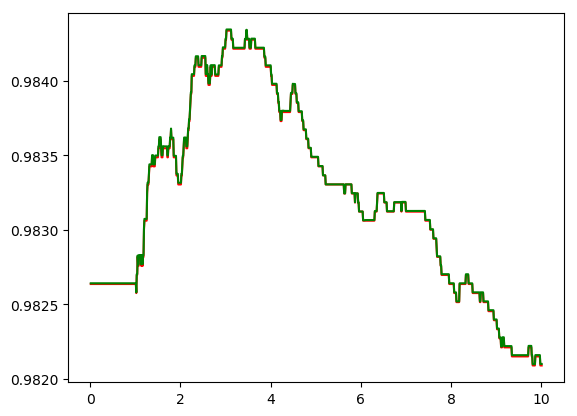

In [30]:
threshold_vs_accuraccy(test_history)